In [173]:
import numpy as np
import matplotlib.pyplot as plt
import LSE_net
import torch
import importlib
import pickle
import datetime

In [174]:
def myLog(x, base):
    return np.log(x)/np.log(base)

def createBetaArray(min, max, grow):
    beta = min
    beta_array = [beta]
    while beta <= max:
        beta = beta*grow
        beta_array.append(beta)
    beta_array = np.array(beta_array)
    return beta_array

def logSumExp(D_array, beta):
    D_min = np.min(D_array)
    D_off = D_array - D_min
    F = -1/beta * np.log(np.sum(np.exp(-beta*D_off))/len(D_array))
    # F = -np.log(np.sum(np.exp(-beta*D_off))) + np.log(len(D_array)) + D_min * beta
    return F



In [175]:
np.random.seed(10)
D_array = np.random.uniform(10,100,20)
print(D_array.min())
beta0 = 1
logSumExp(D_array, beta0)

10.355343969512301


2.7961450054117143

In [176]:
d1 = 10
d2 = 30
d3 = 40
d4 = 50
b0 = 1e-5
l0 = 1/b0 * np.log(4)
l1 = -1/b0 * np.log(np.exp(-b0*d1) + np.exp(-b0*d2) + np.exp(-b0*d3) + np.exp(-b0*d4)) + l0
l2 = -1/b0 * np.log(4)
l3 = l2 + d1 - 1/b0 * np.log((1 + np.exp(-b0*(d2-d1)) + np.exp(-b0*(d3-d1)) + np.exp(-b0*(d4-d1)))/4) + l0
l4 = l2 + d1 - 1/b0 * np.log((1 + np.exp(-b0*d1) + np.exp(-b0*1.5*d1) + np.exp(-b0*4*d1))/4) + l0
print(f'l0:{l0:.3f}\nl1:{l1:.3f}\nl2:{l2:.3f}\nl3:{l3:.3f}\nl4:{l4:.3f}\nl2-l1:{l2+l0-l1:.3f}\nl3-l1:{l3-l1:.3f}\nl4-l1:{l4-l1:.3f}')

l0:138629.436
l1:32.499
l2:-138629.436
l3:32.499
l4:26.249
l2-l1:-32.499
l3-l1:0.000
l4-l1:-6.250


### Create dataset

In [177]:
# function to generate logsum dataset
def logsum_dataset(n_curves, b_min, b_max, b_grow, D_min_range, D_max_range, len_Darray, approx_log_sum_flr, io_scale):
    b_array = createBetaArray(b_min, b_max, b_grow)
    n_beta_per_curve = len(b_array)
    n_data = n_curves * n_beta_per_curve
    In = torch.zeros((n_data, 3), dtype=torch.float32)
    Out = torch.zeros((n_data,1), dtype=torch.float32)

    cnt = 0
    for c in range(n_curves):
        
        D_min = np.random.uniform(D_min_range[0], D_min_range[1])
        D_max = D_min + np.random.uniform(D_max_range[0], D_max_range[1])
        D_array = np.random.uniform(D_min, D_max, len_Darray)
        if approx_log_sum_flr:
            D_array_dum = np.arange(1,len_Darray+1)*2 + D_min
            F_min = logSumExp(D_array_dum, b_min)
        else:
            F_min = logSumExp(D_array, b_min)
        F_min = io_scale * F_min
        F_max = io_scale * np.min(D_array)

        for b in b_array:
            Fb = io_scale * logSumExp(D_array, b)
            In[cnt,:] = torch.tensor([F_min, F_max, b])
            Out[cnt,:] = torch.tensor([Fb])
            cnt += 1

    return In, Out


In [226]:

# beta limits
b_min = 1e-4
b_max = 1e5
b_grow = 1.1
b_array = createBetaArray(b_min, b_max, b_grow)
print(f'len b_array: {b_array.shape}')

# torch input and output arrays
n_curves = 200
len_Darray = 200
D_min_range = [0.001, 1] # minimum value of D_array is picked at random from this range
D_max_range = [1, 10] # maximum value of D_array is picked at random from the range dmin + D_max_range
IO_scale = 0.5

In, Out = logsum_dataset(n_curves, b_min, b_max, b_grow, D_min_range, D_max_range, len_Darray, approx_log_sum_flr=False, io_scale=IO_scale)
print(f'In: {In.size()}\tOut: {Out.size()}')

len b_array: (219,)
In: torch.Size([43800, 3])	Out: torch.Size([43800, 1])


### Visualize Data

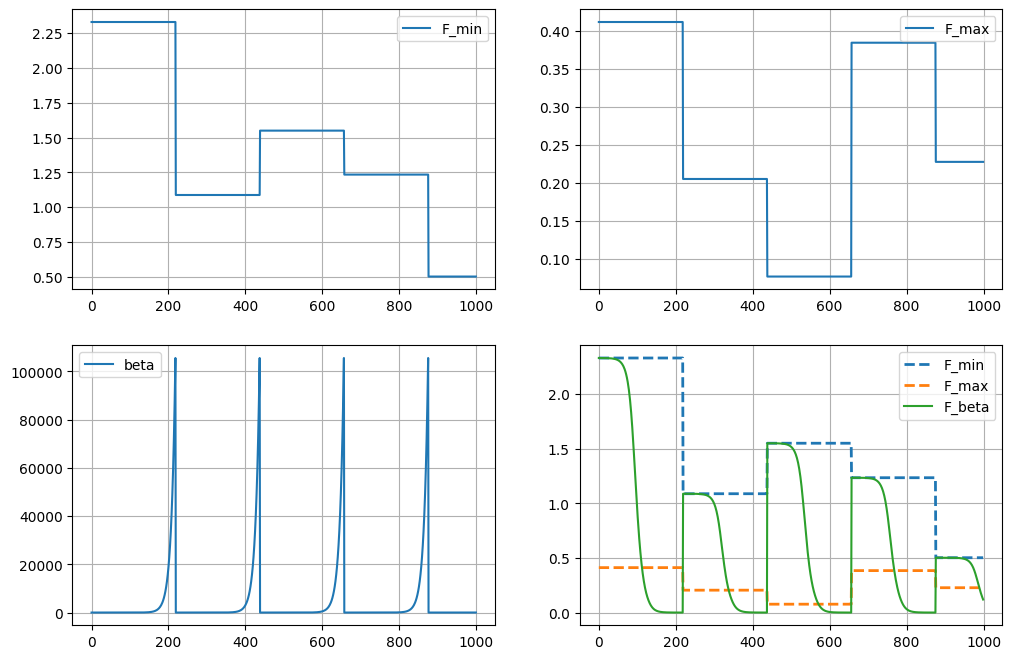

In [227]:

def visualizeData(In, Out, n_end):

    plt.figure(figsize=(12,8))

    plt.subplot(2,2,1)
    plt.plot(In[:n_end,0], label='F_min')
    plt.legend()
    plt.grid()

    plt.subplot(2,2,2)
    plt.plot(In[:n_end,1], label='F_max')
    plt.legend()
    plt.grid()

    plt.subplot(2,2,3)
    plt.plot(In[:n_end,2], label='beta')
    plt.legend()
    plt.grid()

    plt.subplot(2,2,4)
    plt.plot(In[:n_end,0], label='F_min', linestyle='dashed', linewidth=2)
    plt.plot(In[:n_end,1], label='F_max', linestyle='dashed', linewidth=2)
    plt.plot(Out[:n_end], label='F_beta')
    plt.legend()
    plt.grid()

    plt.show()

visualizeData(In, Out, n_end=1000)



### Create neural net for training

In [228]:
importlib.reload(LSE_net)

# create DNN
n_inputs = In.size()[1]
n_outputs = Out.size()[1]
layers = [20, 20, 10]
NN_logSum = LSE_net.dnn(n_inputs, n_outputs, layers)
print(f'DNN model:\n{NN_logSum}')

# create training, and testing dataset
n_samples = In.size()[0]
frac_train = 0.7
n_train = int(frac_train * n_samples)
indices = torch.arange(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]
In_train = In[train_indices]
Out_train = Out[train_indices]
In_test = In[test_indices]
Out_test = Out[test_indices]


DNN model:
dnn(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [229]:
In[0]

tensor([2.3302e+00, 4.1128e-01, 1.0000e-04])

In [230]:
NN_logSum(In).detach().numpy()

array([[-5.2956396e-01],
       [-5.2956128e-01],
       [-5.2955729e-01],
       ...,
       [-1.3218198e+05],
       [-1.4540059e+05],
       [-1.5994103e+05]], dtype=float32)

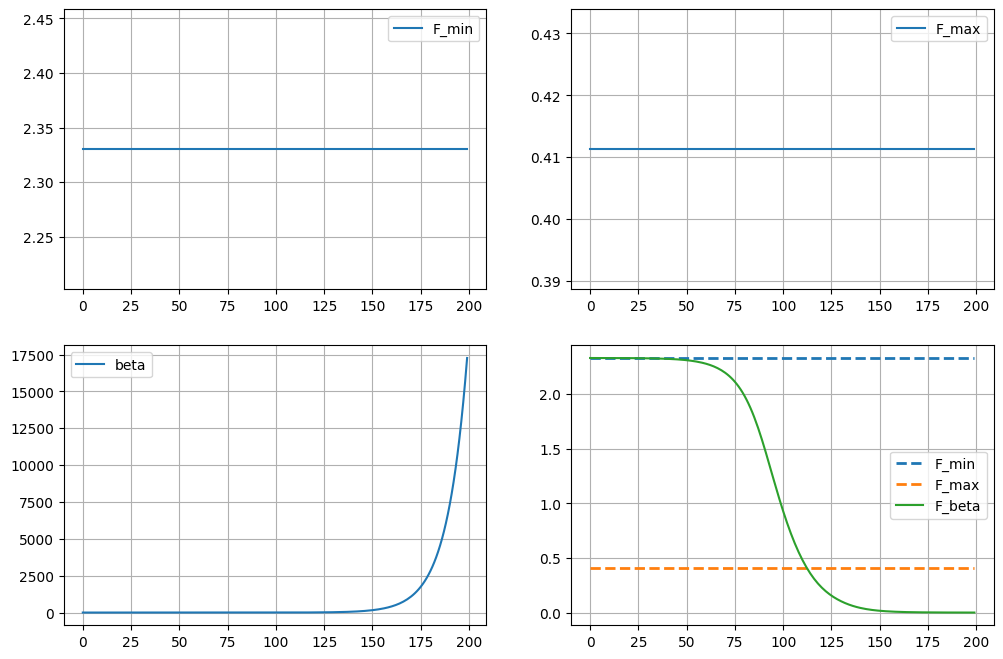

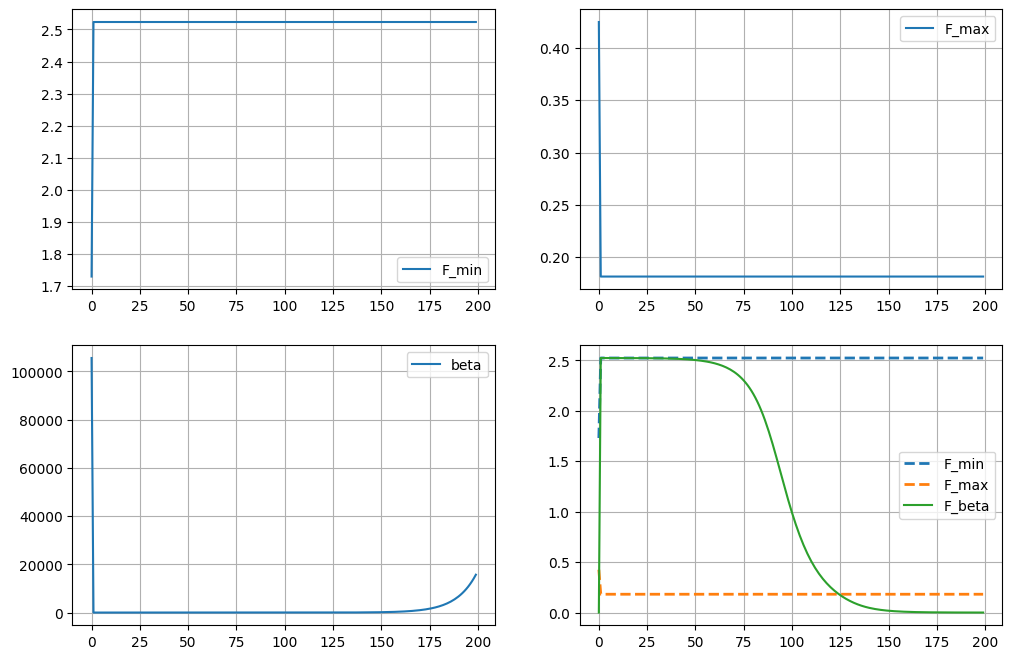

In [231]:
visualizeData(In_train, Out_train, n_end=200)
visualizeData(In_test, Out_test, n_end=200)

### train the network

In [232]:
# dnn configuration
optimizer_name = 'adam'
lr_scheduler = 'ReduceLROnPlateau'
lr0 = 0.0005
epochs = 200
batch_size = 70
loss_coeffs = [1.0, 0.0]
loss_fn, optimizer, scheduler = LSE_net.config_nn(NN_logSum, optimizer_name, lr_scheduler, lr0)
loss = loss_fn(NN_logSum(In_train[0]), Out_train[0]).detach().item()
training_loss, learning_rate, stopping_epoch = LSE_net.train_nn1(
    NN_logSum, In_train, Out_train, loss_fn,
    optimizer, scheduler, loss_coeffs=loss_coeffs,
    epochs=epochs, batch_size=batch_size, allowPrint=True)



---------------------------------
training data size = 30659
training batch size = 70
n_epochs = 200
n_batches = 438
loss weights = [1.0, 0.0]
---------------------------------

batch_split
0 69
70 139
140 209
210 279
280 349
350 419
420 489
490 559
560 629
630 699
700 769
770 839
840 909
910 979
980 1049
1050 1119
1120 1189
1190 1259
1260 1329
1330 1399
1400 1469
1470 1539
1540 1609
1610 1679
1680 1749
1750 1819
1820 1889
1890 1959
1960 2029
2030 2099
2100 2169
2170 2239
2240 2309
2310 2379
2380 2449
2450 2519
2520 2589
2590 2659
2660 2729
2730 2799
2800 2869
2870 2939
2940 3009
3010 3079
3080 3149
3150 3219
3220 3289
3290 3359
3360 3429
3430 3499
3500 3569
3570 3639
3640 3709
3710 3779
3780 3849
3850 3919
3920 3989
3990 4059
4060 4129
4130 4199
4200 4269
4270 4339
4340 4409
4410 4479
4480 4549
4550 4619
4620 4689
4690 4759
4760 4829
4830 4899
4900 4969
4970 5039
5040 5109
5110 5179
5180 5249
5250 5319
5320 5389
5390 5459
5460 5529
5530 5599
5600 5669
5670 5739
5740 5809
5810 5879
58

In [221]:

# trained_lse_info = {
#     'model_state_dict': NN_logSum.state_dict(), 
#     'n_inputs':n_inputs,
#     'n_outputs':n_outputs,
#     'layers':layers,
#     'b_arr':b_array, 
#     'len_Darray':len_Darray, 
#     'D_min_range':D_min_range,
#     'D_max_range':D_max_range,
#     'io_scale':IO_scale,
#     'n_samples':n_samples,
#     'frac_train':frac_train,
#     'optimizer_name':optimizer,
#     'optimize_state_dict':optimizer.state_dict(),
#     'lr_scheduler':lr_scheduler,
#     'lr0':lr0,
#     'loss_fn':loss_fn,
#     'epochs':epochs,
#     'batch_size':batch_size,
#     'training_loss':training_loss,
#     'learning_rate':learning_rate,
# }


### Save the trained model

In [222]:
# # str(datetime.datetime.today()).split()
# current_time = datetime.datetime.now()
# yyyy = str(current_time.year)
# mm = str(current_time.month)
# dd = str(current_time.day)
# hh = str(current_time.hour)
# mt = str(current_time.minute)
# sec = str(current_time.second)
# current_datetime = yyyy + '_' + mm + '_' + dd + '__' + hh + '_' + mt + '_' + sec 
# print(current_datetime)

2025_4_17__15_56_48


In [224]:
# filename = 'logSumExp_models/lse_' + current_datetime + '.pth'

# torch.save(trained_lse_info, filename)

### plot training loss and learning rate

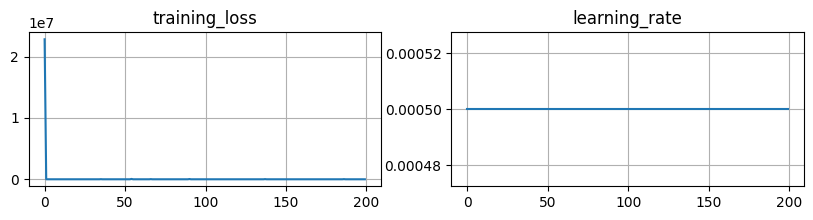

In [233]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.plot(training_loss)
plt.title('training_loss')
plt.grid()
plt.subplot(1,2,2)
plt.plot(learning_rate)
plt.title('learning_rate')
plt.grid()

plt.show()


### Evaluate the network on a validation dataset

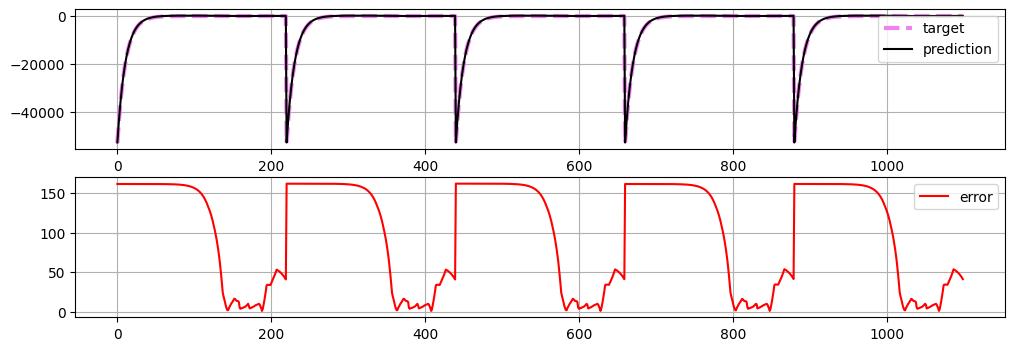

In [236]:
b_min_v = b_array[0]
b_max_v = b_array[-1]
b_grow_v = 1.1
b_array_v = createBetaArray(b_min_v, b_max_v, b_grow_v)
n_curves_v = 5
D_min_range_v = [0.0001,1]
D_max_range_v = [1,2]
len_Darray_v = len_Darray
In_val, Out_val = logsum_dataset(n_curves=n_curves_v, 
                    b_min=b_min_v, b_max=b_max_v, b_grow=b_grow_v, D_min_range=D_min_range_v, 
                    D_max_range=D_max_range_v, len_Darray=len_Darray_v, 
                    approx_log_sum_flr=True, io_scale=IO_scale)
pred_val = NN_logSum(In_val).detach()

st = 0
Out_val_np = (Out_val.numpy().flatten()/IO_scale)[st:] - (1 / np.tile(b_array_v, n_curves_v) * np.log(len_Darray_v))[st:] + (In_val[:,1].numpy().flatten()/IO_scale)[st:]
pred_val_np = (pred_val.numpy().flatten()/IO_scale)[st:] - (1 / np.tile(b_array_v, n_curves_v) * np.log(len_Darray_v))[st:] + (In_val[:,1].numpy().flatten()/IO_scale)[st:]

plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(Out_val_np, label='target', color='violet', linestyle='dashed', linewidth=3)
plt.plot(pred_val_np, label='prediction', color='black')
plt.grid()
plt.xticks()
plt.legend()

plt.subplot(2,1,2)
error_val = np.abs(pred_val_np - Out_val_np)
# plt.subplot(1,2,2)
plt.plot(error_val, label='error', color='red')
plt.legend()
plt.grid()

plt.show()


In [144]:
Out_val_np.shape

(1120,)

In [145]:
b_array_v.shape

(280,)

In [146]:
np.tile(b_array_v, n_curves_v).shape

(1120,)